In [25]:
# Import necessary libraries
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import (
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PowerTransformer

# Import custom tools and transformers
from tools.DataLoader import DataLoader
from tools.EDA import EDA
from tools.SLModelEvaluator import SLModelEvaluator
from tools.SLModelTrainer import SLModelTrainer
from transformers.RemoveFeaturesTransformer import RemoveFeaturesTransformer
from transformers.DropHighNaNColumnsTransformer import DropHighNaNColumnsTransformer

In [26]:
# Step 1: Load Data using DataLoader
data_loader = DataLoader(request_type="local", path="db/final_proj_data.csv")
df = data_loader.load_data()

In [27]:
data_loader_valid = DataLoader(request_type="local", path="db/final_proj_test.csv")
df_valid = data_loader_valid.load_data()

In [28]:
# Step 2: Perform EDA using the EDA class
eda = EDA(df)
eda.perform_full_eda()

Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 231 entries, Var1 to y
dtypes: float64(191), int64(2), object(38)
memory usage: 17.6+ MB


None

,Column,Has_Nulls,Dtype
Var1,Var1,True,float64
Var2,Var2,True,float64
Var3,Var3,True,float64
Var4,Var4,True,float64
Var5,Var5,True,float64
...,...,...,...
Var227,Var227,False,object
Var228,Var228,False,object
Var229,Var229,True,object
Var230,Var230,True,float64



Dataset Shape:

(10000, 231)

Descriptive Statistics:



,count,mean,std,min,25%,50%,75%,max
Var1,133.0,14.977444,66.456008,0.0,0.000,0.00,16.000,680.0
Var2,266.0,0.000000,0.000000,0.0,0.000,0.00,0.000,0.0
Var3,266.0,341.052632,2810.606975,0.0,0.000,0.00,0.000,42588.0
Var4,280.0,0.096429,0.928243,0.0,0.000,0.00,0.000,9.0
Var5,241.0,233810.124481,553230.515446,0.0,0.000,0.00,117235.000,3024000.0
...,...,...,...,...,...,...,...,...
Var189,4206.0,272.455064,86.752531,6.0,204.000,270.00,330.000,642.0
Var190,43.0,25725.112326,37487.484852,0.0,1312.875,10853.82,37491.525,191167.2
Var209,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Var230,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Missing Values:



Var1       9867
Var2       9734
Var3       9734
Var4       9720
Var5       9759
          ...  
Var227        0
Var228        0
Var229     5561
Var230    10000
y             0
Length: 231, dtype: int64


Sample Data:



,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,y
0,NaN,NaN,NaN,NaN,NaN,812.0,14.0,NaN,NaN,NaN,...,catzS2D,jySVZNlOJy,NaN,xG3x,Aoh3,ZI9m,ib5G6X1eUxUn6,mj86,NaN,0
1,NaN,NaN,NaN,NaN,NaN,2688.0,7.0,NaN,NaN,NaN,...,i06ocsg,LM8l689qOp,NaN,kG3k,WqMG,RAYp,55YFVY9,mj86,NaN,0
2,NaN,NaN,NaN,NaN,NaN,1015.0,14.0,NaN,NaN,NaN,...,P6pu4Vl,LM8l689qOp,NaN,kG3k,Aoh3,ZI9m,R4y5gQQWY8OodqDV,am7c,NaN,0
3,NaN,NaN,NaN,NaN,NaN,168.0,0.0,NaN,NaN,NaN,...,BNrD3Yd,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,14.0,0.0,NaN,NaN,NaN,...,3B1QowC,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,0


In [29]:
eda.missing_values_percentage(target="y")

Percentage of Missing Values in Each Column:


,Column,Missing Percentage
229,Var230,100.0
174,Var175,100.0
54,Var55,100.0
38,Var39,100.0
140,Var141,100.0
...,...,...
201,Var202,0.0
198,Var199,0.0
197,Var198,0.0
195,Var196,0.0



Summary of Missing Values:


,Average Missing Percentage,Median Missing Percentage,Maximum Missing Percentage,Minimum Missing Percentage,Standard Deviation of Missing Percentage,First Quartile (Q1) of Missing Percentage,Third Quartile (Q3) of Missing Percentage,Interquartile Range (IQR) of Missing Percentage
0,69.715174,97.34,100.0,0.0,41.833357,10.2,98.67,88.47


In [30]:
evaluator = SLModelEvaluator()

In [31]:
X = df.drop(columns=["y"])
y = df["y"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [32]:
# Define categorical transformer for RandomForest
cat_transformer_rf = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", TargetEncoder()),
    ]
)

# Define numerical transformer for RandomForest
num_transformer_rf = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
    ]
)

# Define preprocessor for RandomForest
preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", num_transformer_rf, make_column_selector(dtype_include=np.number)),
        (
            "cat",
            cat_transformer_rf,
            make_column_selector(dtype_include=[object, "category"]),
        ),
    ],
    n_jobs=-1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [33]:
# Define categorical transformer for GradientBoosting
cat_transformer_gb = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", TargetEncoder()),
    ]
)

# Define numerical transformer for GradientBoosting
num_transformer_gb = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

# Define preprocessor for GradientBoosting
preprocessor_gb = ColumnTransformer(
    transformers=[
        ("num", num_transformer_gb, make_column_selector(dtype_include=np.number)),
        (
            "cat",
            cat_transformer_gb,
            make_column_selector(dtype_include=[object, "category"]),
        ),
    ],
    n_jobs=-1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [34]:
X_train_F = DropHighNaNColumnsTransformer(threshold=0.8).fit_transform(X_train)
X_train_T = preprocessor_gb.fit_transform(X_train_F, y_train)

# X_F = DropHighNaNColumnsTransformer(threshold=0.8).fit_transform(X)
# X_T = preprocessor_gb.fit_transform(X_F, y)

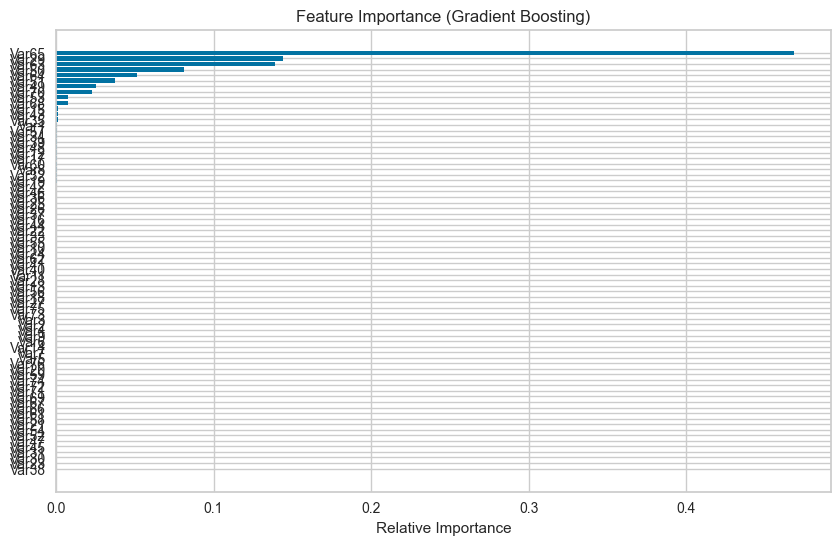

,Feature,Importance
8,Var53,0.007640
9,Var68,0.007442
10,Var15,0.001486
11,Var43,0.001263
12,Var35,0.001092
...,...,...
71,Var45,0.000000
72,Var31,0.000000
73,Var30,0.000000
74,Var23,0.000000



Summary Statistics for Low Importance Features:


,mean,median,min,max,sum
Importance,0.000437,0.000104,0.0,0.00764,0.0297


In [35]:
low_importance_features = evaluator.feature_importance(
    X_train_T,
    y_train,
    df,
    print_zero_importance=True,
    importance_threshold=0.01,
    model_type="gradient_boosting",
)

# low_importance_features = evaluator.feature_importance(
#     X_T,
#     y,
#     df,
#     print_zero_importance=True,
#     importance_threshold=0.01,
#     model_type="gradient_boosting",
# )

In [36]:
# Full preprocessing pipeline for RandomForest without nested Pipelines
full_pipeline_random_forest = Pipeline(
    steps=[
        ("drop_high_nan", DropHighNaNColumnsTransformer()),
        ("preprocessing", preprocessor_rf),
        # ("scaler", StandardScaler()),
        # ("pca", PCA(n_components=0.95)),
        ("model", RandomForestClassifier(random_state=42)),
    ]
)

In [37]:
# Full preprocessing pipeline for GradientBoosting without nested Pipelines

full_pipeline_gradient_boosting = Pipeline(
    steps=[
        ("drop_high_nan", DropHighNaNColumnsTransformer()),
        # (
        #     "remove_features",
        #     RemoveFeaturesTransformer(features=[]),
        # ),
        ("preprocessing", preprocessor_gb),
        # ("scaler", StandardScaler()),
        # ("pca", PCA(n_components=0.95)),
        ("model", GradientBoostingClassifier(random_state=42)),
    ]
)

In [38]:
# Full preprocessing pipeline for HistGradientBoosting without nested Pipelines
full_pipeline_hist_gradient_boosting = ImbPipeline(
    steps=[
        ("drop_high_nan", DropHighNaNColumnsTransformer()),
        # (
        #     "remove_features",
        #     RemoveFeaturesTransformer(features=low_importance_features),
        # ),
        ("preprocessing", preprocessor_gb),
        # ("power", PowerTransformer()),
        # ("smote", SMOTE(random_state=42)),
        # ("scaler", StandardScaler()),
        # ("pca", PCA(n_components=0.95)),
        ("model", HistGradientBoostingClassifier(random_state=42)),
    ]
)

In [39]:
# # Define the parameter grid for RandomForest
# param_grids = {
#     "random_forest": {
#         "model__n_estimators": [100, 200, 300],
#         "model__max_depth": [10, 20, 30],
#         "model__min_samples_split": [2, 5, 10],
#         "model__min_samples_leaf": [1, 2, 4],
#         "model__bootstrap": [True],
#         "drop_high_nan__threshold": [0.8],
#     },
#     "gradient_boosting": {
#         "model__n_estimators": [100, 200, 300],
#         "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
#         "model__max_depth": [3, 5, 7],
#         "model__min_samples_split": [2, 5, 10],
#         "model__min_samples_leaf": [1, 2, 4],
#         "model__subsample": [0.8, 1.0],
#         "drop_high_nan__threshold": [0.5],
#     },
#     "hist_gradient_boosting": {
#         "model__learning_rate": [0.1, 0.2, 0.3],
#         "model__max_iter": [100, 200, 300],
#         "model__max_leaf_nodes": [31, 63, 127],
#         "model__max_depth": [3, 5, 7],
#         "model__min_samples_leaf": [20, 40, 60],
#         "model__l2_regularization": [0.1, 0.2, 0.3],
#         "drop_high_nan__threshold": [0.8],
#     },
# }

# Define the parameter grid for RandomForest
param_grids = {
    "random_forest": {
        # "selectkbest___k": [10, 15],
        # "smote__k_neighbors": [7, 9],
        "model__n_estimators": [100],
        "model__max_depth": [10],
        "model__min_samples_split": [5],
        "model__min_samples_leaf": [2],
        "model__bootstrap": [True],
        "drop_high_nan__threshold": [0.8],
    },
    "gradient_boosting": {
        # "selectkbest___k": [10, 15],
        # "smote__k_neighbors": [7, 9],
        "model__n_estimators": [100],
        "model__learning_rate": [0.01],
        "model__max_depth": [3, 5, 7],
        "model__min_samples_split": [5],
        "model__min_samples_leaf": [2],
        "model__subsample": [0.6, 0.8],
        "drop_high_nan__threshold": [0.5],
    },
    "hist_gradient_boosting": {
        # "selectkbest___k": [10, 15],
        # "smote__k_neighbors": [7, 9],
        "model__learning_rate": [0.1],
        "model__max_iter": [100],
        "model__max_leaf_nodes": [31],
        "model__max_depth": [3, 5, 7],
        "model__min_samples_leaf": [40],
        "model__l2_regularization": [0.3],
        "drop_high_nan__threshold": [0.8],
    },
}

In [40]:
# Combine pipelines into a dictionary
model_pipelines = {
    "random_forest": full_pipeline_random_forest, 
    "gradient_boosting": full_pipeline_gradient_boosting,
    "hist_gradient_boosting": full_pipeline_hist_gradient_boosting,
}

In [41]:
model_trainer = SLModelTrainer()

model_trainer.train(
    X_train, y_train, model_pipelines, param_grids, scoring="balanced_accuracy", cv=5
)
# model_trainer.train(
#     X, y, model_pipelines, param_grids, scoring="balanced_accuracy", cv=5
# )

In [42]:
best_models = model_trainer.best_estimators
best_params = model_trainer.best_params
best_scores = model_trainer.best_scores
best_model = model_trainer.best_model_name

In [43]:
evaluator.visualize_pipeline(model_name=best_model, best_models=best_models)

Pipeline(steps=[('drop_high_nan', DropHighNaNColumnsTransformer()),
                ('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x701094641340>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   TargetEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7010fc5297f0>)],
                                   verbose_feature_names_out=False)),
                ('model',
                 HistGradientBoostingClassifier(l2_regularization=0.3,
                                                max_depth=3,
                                                min_samples_leaf=40,
                                                random_state=42))])

In [44]:
evaluator.display_results(X_valid=X_test, y_valid=y_test, best_models=best_models, best_params=best_params, best_scores=best_scores, best_model_name=best_model, help_text=True)

# evaluator.display_results(
#     X_valid=X,
#     y_valid=y,
#     best_models=best_models,
#     best_params=best_params,
#     best_scores=best_scores,
#     best_model_name=best_model,
#     help_text=True,
# )

Evaluation Metrics for Validation Set:


,Model,Accuracy,Balanced Accuracy,F1 Score,Precision,Recall
2,hist_gradient_boosting,0.8920,0.660338,0.876552,0.877043,0.8920
0,random_forest,0.8830,0.593852,0.853970,0.864169,0.8830
1,gradient_boosting,0.8815,0.580082,0.848653,0.863165,0.8815



Best Parameters for Each Model (found during cross-validation):


,Model,drop_high_nan__threshold,model__bootstrap,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate,model__subsample,model__l2_regularization,model__max_iter,model__max_leaf_nodes
0,random_forest,0.8,True,10,2,5,100,NaN,NaN,NaN,NaN,NaN
1,gradient_boosting,0.5,NaN,3.0,2.0,5.0,100.0,0.01,0.8,NaN,NaN,NaN
2,hist_gradient_boosting,0.8,NaN,3.0,40.0,NaN,NaN,0.1,NaN,0.3,100.0,31.0



Overall Best Model and Score (based on cross-validation score):


,Overall Best Model,Score (based on cross-validation score)
0,hist_gradient_boosting,0.618714



Metric Explanations:
Accuracy: The ratio of correctly predicted instances to the total instances.
  - Range: [0, 1], higher is better.
  - Higher values indicate better model performance.
Balanced Accuracy: The average of recall obtained on each class.
  - Range: [0, 1], higher is better.
  - Higher values indicate better model performance.
F1 Score: The harmonic mean of precision and recall.
  - Range: [0, 1], higher is better.
  - Higher values indicate better model performance.
Precision: The ratio of correctly predicted positive observations to the total predicted positives.
  - Range: [0, 1], higher is better.
  - Higher values indicate better model performance.
Recall: The ratio of correctly predicted positive observations to the all observations in actual class.
  - Range: [0, 1], higher is better.
  - Higher values indicate better model performance.


In [45]:
evaluator.validate_on_test(X_test, y_test, best_models[best_model], best_model_name=best_model)

# evaluator.validate_on_test(
#     X, y, best_models[best_model], best_model_name=best_model
# )

Results for hist_gradient_boosting:


,Accuracy,Balanced Accuracy,F1 Score,Precision,Recall
hist_gradient_boosting,0.892,0.660338,0.876552,0.877043,0.892


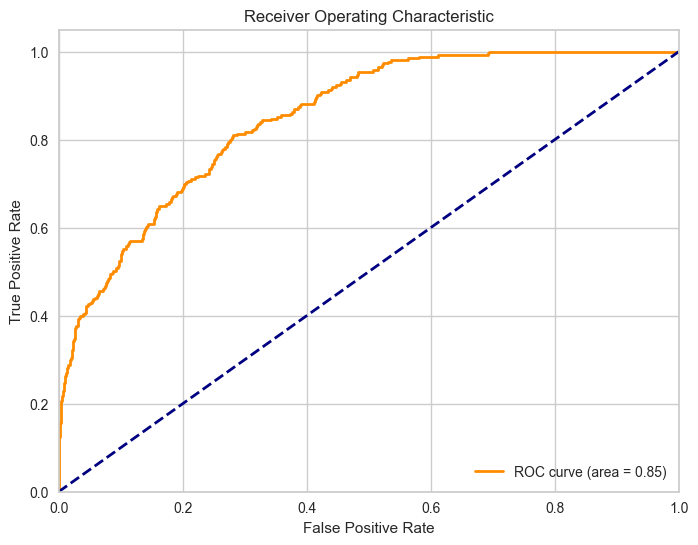

In [46]:
evaluator.plot_roc_curve(
    model=best_models[best_model], X_test=X_test, y_test=y_test
)

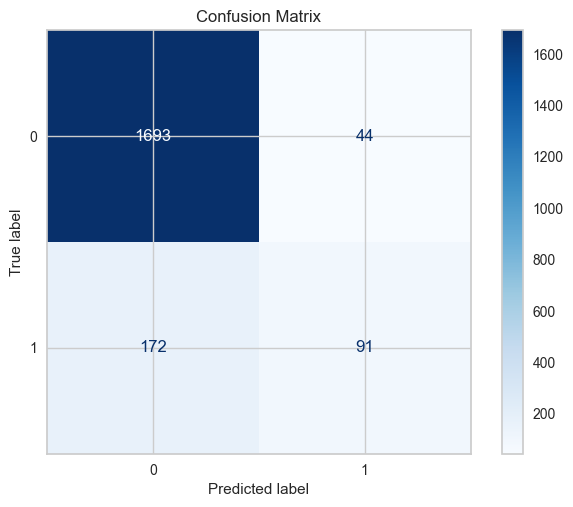

In [47]:
evaluator.plot_confusion_matrix(
    model=best_models[best_model], X_test=X_test, y_test=y_test
)

In [48]:
# predictions = best_models[best_model].predict(df_valid)

# output = pd.DataFrame({"index": df_valid.index, "y": predictions})

# output.head()